<a href="https://colab.research.google.com/github/vaibhavm291/DESIGN-AND-DEVELOPMENT-OF-HYBRID-MODEL-FOR-EFFICIENT-PREDICTION-OF-STOCK-PRICES/blob/main/LSTM%20(TCS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error
from pandas.tseries.offsets import BDay
from datetime import datetime

In [17]:
# 1. Fetch stock data
ticker = "TCS.NS"  # or "AAPL", "RELIANCE.NS"
today = datetime.today().strftime('%Y-%m-%d')
data = yf.download(ticker, start="2000-01-01", end=today)
close_prices = data[["Close"]].values

/tmp/ipython-input-17-2224455207.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2000-01-01", end=today)
[*********************100%***********************]  1 of 1 completed


In [18]:
# 2. Feature Engineering
data["MA10"] = data["Close"].rolling(window=10).mean()
data["MA50"] = data["Close"].rolling(window=50).mean()
data["Returns"] = data["Close"].pct_change()
display("Data before dropna():")
display(data.head())
display("Shape before dropna():", data.shape)

'Data before dropna():'

Price,Close,High,Low,Open,Volume,MA10,MA50,Returns
Ticker,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS,,,
Date,,,,,,,,
2002-08-12,28.175669,28.388583,27.483695,27.483695,212976,NaN,NaN,NaN
2002-08-13,27.794210,28.663613,27.590168,28.211169,153576,NaN,NaN,-0.013539
2002-08-14,25.877964,27.856292,25.354547,27.856292,822776,NaN,NaN,-0.068944
2002-08-15,25.877964,25.877964,25.877964,25.877964,0,NaN,NaN,0.000000
2002-08-16,25.815859,26.969145,25.372287,25.744888,811856,NaN,NaN,-0.002400


'Shape before dropna():'

(5674, 8)

In [19]:
# 3. Select useful features
features = ["Close", "MA10", "MA50", "Returns", "Volume"]
data = data[features]
display("Data before dropna():")
display(data.head())
display("Shape before dropna():", data.shape)
data.dropna(inplace=True)
display("Data after dropna():")
display(data.head())
display("Shape after dropna():", data.shape)

'Data before dropna():'

Price,Close,MA10,MA50,Returns,Volume
Ticker,TCS.NS,,,,TCS.NS
Date,,,,,
2002-08-12,28.175669,NaN,NaN,NaN,212976
2002-08-13,27.794210,NaN,NaN,-0.013539,153576
2002-08-14,25.877964,NaN,NaN,-0.068944,822776
2002-08-15,25.877964,NaN,NaN,0.000000,0
2002-08-16,25.815859,NaN,NaN,-0.002400,811856


'Shape before dropna():'

(5674, 5)

/tmp/ipython-input-19-915319367.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


'Data after dropna():'

Price,Close,MA10,MA50,Returns,Volume
Ticker,TCS.NS,,,,TCS.NS
Date,,,,,
2002-10-18,27.545792,26.930120,27.923542,0.021045,512312
2002-10-21,27.971640,27.076501,27.919461,0.015460,646296
2002-10-22,26.960278,27.049887,27.902783,-0.036157,229384
2002-10-23,26.836079,27.080050,27.921945,-0.004607,153320
2002-10-24,26.365881,27.060530,27.931703,-0.017521,168744


'Shape after dropna():'

(5625, 5)

In [21]:
# 4. Scale the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [23]:
# 5. Prepare data for LSTM (60-day lookback)
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i, 0])  # Predict only 'Close'
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)


In [25]:
# 6. Build LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
# 7. Train the model
model.fit(X, y, epochs=50, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - loss: 3.1650e-04 - val_loss: 0.0020
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 3.2239e-04 - val_loss: 6.2884e-04
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - loss: 2.9229e-04 - val_loss: 3.7193e-04
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 3.5390e-04 - val_loss: 2.9301e-04
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 3.3021e-04 - val_loss: 4.0383e-04
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - loss: 3.2200e-04 - val_loss: 0.0012
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 3.2598e-04 - val_loss: 7.5656e-04
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 2.7902e-04 - val_loss: 0.0020
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - loss: 3.3230e-04 - val_loss: 8.1349e-04
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - loss: 3.2395e-04 - val_loss: 0.0018
Epoch 11/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step 

In [29]:
# 8. Predict next trading day
last_60 = scaled_data[-60:]
X_pred = np.expand_dims(last_60, axis=0)
pred_scaled = model.predict(X_pred)

# 9. Inverse transform the prediction (padding with dummy 0s for extra features)
dummy = np.zeros((1, len(features) - 1))
full_input = np.hstack((pred_scaled, dummy))
predicted_price = scaler.inverse_transform(full_input)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [31]:
# 10. Show results
today = data.index[-1].date()
next_day = today + BDay(1)
print("📅 Last Trading Day:", today)
print("💰 Last Closing Price:", round(data.iloc[-1]["Close"], 2))
print("📈 Predicted Price for", next_day.date(), ":", round(predicted_price, 2))

📅 Last Trading Day: 2025-06-20
💰 Last Closing Price: Ticker
TCS.NS    3435.7
Name: 2025-06-20 00:00:00, dtype: float64
📈 Predicted Price for 2025-06-23 : 3467.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step 


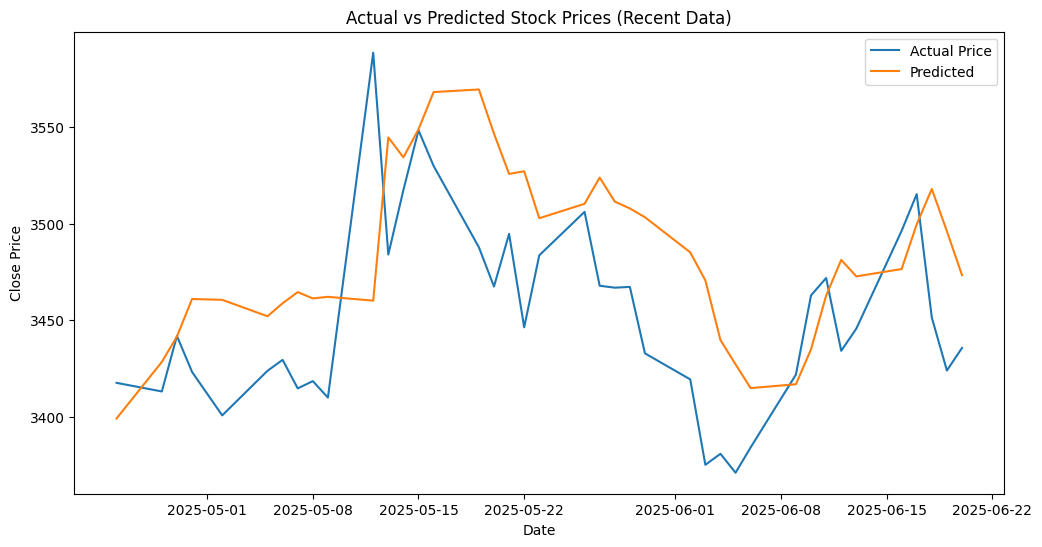

In [32]:
recent_data = data.tail(100)
recent_X = recent_data[features].values # Select all features
# Scale the recent data for prediction
scaled_recent_X = scaler.transform(recent_X)

# Prepare sequences for prediction
sequence_length = 60
X_recent = []
for i in range(sequence_length, len(scaled_recent_X)):
    X_recent.append(scaled_recent_X[i-sequence_length:i])

X_recent = np.array(X_recent)
# The input shape for the LSTM should be (samples, time steps, features)
# In this case, time steps is sequence_length and features is the number of selected features
X_recent = np.reshape(X_recent, (X_recent.shape[0], X_recent.shape[1], len(features)))

recent_preds_scaled = model.predict(X_recent)

# Inverse transform the predictions (padding with dummy 0s for extra features if necessary)
# The scaler was fitted on 5 features, so the inverse transform expects 5 features.
# The model predicts only the 'Close' price, which is the first feature.
# We need to add dummy values for the other features for inverse transformation.
dummy = np.zeros((recent_preds_scaled.shape[0], len(features) - 1))
recent_preds = scaler.inverse_transform(np.hstack((recent_preds_scaled, dummy)))[:, 0] # Inverse transform and select only the 'Close' price

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(recent_data.index[sequence_length:], recent_data["Close"][sequence_length:], label="Actual Price")
plt.plot(recent_data.index[sequence_length:], recent_preds, label="Predicted")
plt.title("Actual vs Predicted Stock Prices (Recent Data)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()